<a href="https://colab.research.google.com/github/Manu1ND/colab/blob/main/PaperSpace_Template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fastai -q --upgrade
!pip install --upgrade albumentations
!apt-get install zip unzip
!pip install gdown

In [ ]:
import gdown
import os
import pandas as pd
gdown.download('https://drive.google.com/u/1/uc?id=1PsX8ULvWg-peKtUduyTqkyxfxXoom13S', './owl.zip', quiet=False)
!unzip ./owl.zip
!rm ./owl.zip

# Specs

In [8]:
  !nvidia-smi

Fri Feb 11 10:02:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
import warnings
warnings.filterwarnings('ignore')

# Import dependencies

In [10]:
from fastai.vision.all import *
import gdown
import os
import pandas as pd

# Preprocessing

In [11]:
seed = 1000

def seed_everything(seed = seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything()

In [12]:
path = Path('./Dataset_OWL_COD10K_v3/')
train_images = path/'Train/Image'
train_labels = path/'Train/GT'
test_name = "Test"
test_images = path/test_name/'Image'
test_labels = path/test_name/'GT'

In [13]:
def get_y_fn(x): 
  return Path(str(x).replace("Image","GT").replace(".jpg",".png"))

In [14]:
def ParentSplitter(x):
    return Path(x).parent.name==test_name

In [15]:
codes = ['background','owl']
name2id = {v:k for k,v in enumerate(codes)}
print(name2id)
void_code = name2id['owl']

{'background': 0, 'owl': 1}


In [16]:
def foreground_acc(input, target):
    target = cast(target.squeeze(1), TensorBase)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [17]:
class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0
    def __init__(self, aug): 
        self.aug = aug
    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])

In [18]:
class TargetMaskConvertTransform(ItemTransform):
    def __init__(self): 
        pass
    def encodes(self, x):
        img,mask = x
        mask = np.array(mask)
        mask[mask==255]=1
        mask = PILMask.create(mask)
        return img, mask

# Compute Method

## Constant

In [19]:
size = 224
bs = 6
splitter = RandomSplitter(valid_pct=0.2, seed=seed)
item_tfms = [Resize((size,size)), TargetMaskConvertTransform()]
batch_tfms = []
arch = resnet34
pretrained=True
metrics = [foreground_acc, Dice(), JaccardCoeff()]
act_cls = nn.ReLU
self_attention = False
lr = 1e-3
wd = None
epochs = 200

In [20]:
monitor_training = "valid_loss"
comp_training = np.less

monitor_evaluating = "dice"
comp_evaluating = np.greater

patience = 50

In [21]:
# Import csv or make new dataframe
if os.path.isfile("result.csv"):
  result_df = pd.read_csv("result.csv", header=[0,1], index_col=[0,1])
else:
  col_names = [('method_type',''), ('method_name',''), ('Training','valid_loss'),("Training",'foreground_acc'),("Training",'dice'),('Training','jaccard_coeff'),('Testing','valid_loss'),("Testing",'foreground_acc'),("Testing",'dice'),('Testing','jaccard_coeff')]
  col_list = pd.MultiIndex.from_tuples(col_names)
  result_df = pd.DataFrame(columns = col_list).set_index([('method_type'), ('method_name')])

result_df = result_df.sort_index(0)

## Compute Function

In [22]:
def compute(method_name, method_type, size = size, splitter=splitter, item_tfms = item_tfms, batch_tfms = batch_tfms, bs = bs, arch = arch, pretrained = pretrained, metrics = metrics,
            act_cls = act_cls, self_attention = self_attention, lr = lr, wd = wd, epochs = epochs, patience = patience):
  
  if(len(batch_tfms)):
    transformPipeline = Compose(batch_tfms,p=1)
    transformPipeline = SegmentationAlbumentationsTransform(transformPipeline)
    item_tfms.append(transformPipeline)

  callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor = monitor_training, comp = comp_training, patience = patience),
    SaveModelCallback(monitor = monitor_training, comp = comp_training, every_epoch = False, fname = method_name)  
  ]
  
  dblock = DataBlock(blocks = (ImageBlock, MaskBlock(codes)),
                  get_items = get_image_files,
                  splitter = splitter,
                  get_y = get_y_fn,
                  item_tfms = item_tfms,
                  batch_tfms = [Normalize.from_stats(*imagenet_stats)]
                  )
  
  dls = dblock.dataloaders(train_images, bs=bs, num_workers=0)

  seed_everything()

  learn = unet_learner(dls, arch, pretrained = pretrained, metrics = metrics, wd=wd,
                       act_cls = act_cls, self_attention = self_attention)

  if(lr):
    learn.fit_one_cycle(epochs, lr, cbs=callbacksFitBeforeUnfreeze)
  else:
    lr = learn.lr_find()
    print("~~~~~~~~~~~~~~~~~~~~~~~~~Learning Rate~~~~~~~~~~~~~~~~~~~~~~~~~")
    print(lr[0].item())
    learn.fit_one_cycle(epochs, lr[0].item(), cbs=callbacksFitBeforeUnfreeze)

  # learn.load(method_name)
  # learn.unfreeze()
  # lr = learn.lr_find()
  # learn.fit_one_cycle(25, slice(lr[0].item()),cbs=callbacksFitBeforeUnfreeze)

  print("~~~~~~~~~~~~~~~~~~~~~~~~~Training Result~~~~~~~~~~~~~~~~~~~~~~~~~")
  train_validate = learn.validate()
  print(train_validate)

  test_img = get_image_files(test_images)
  dl = learn.dls.test_dl(test_img, with_labels=True)
  print("~~~~~~~~~~~~~~~~~~~~~~~~~Testing Result~~~~~~~~~~~~~~~~~~~~~~~~~~")
  test_validate = learn.validate(dl=dl)
  print(test_validate)
  
  result_df.loc[(method_type, method_name), :] = train_validate + test_validate
  #result_df.to_csv('result.csv')
  result_df.to_csv(f'result.csv')

  # Delete pth file
  !rm -rf ./models

  return learn

# Experiments

#### Reflection

epoch,train_loss,valid_loss,foreground_acc,dice,jaccard_coeff,time
0,0.302094,0.290769,0.999845,0.000000,0.000000,01:12
1,0.250737,0.166183,0.994493,0.293654,0.172095,01:12
2,0.205652,0.143059,0.991535,0.665742,0.498960,01:12
3,0.172186,0.170389,0.996145,0.665930,0.499171,01:12
4,0.167155,0.128153,0.974528,0.738072,0.584877,01:12
5,0.151648,0.125332,0.991748,0.723809,0.567164,01:12
6,0.141637,0.213158,0.999179,0.496566,0.330288,01:12


Better model found at epoch 0 with valid_loss value: 0.2907694876194.


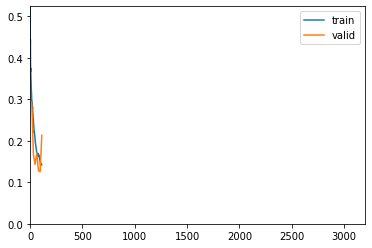

Better model found at epoch 1 with valid_loss value: 0.16618341207504272.
Better model found at epoch 2 with valid_loss value: 0.14305926859378815.
Better model found at epoch 4 with valid_loss value: 0.128152534365654.
Better model found at epoch 5 with valid_loss value: 0.12533222138881683.


In [ ]:
compute("Reflection", "Resize 512x512", item_tfms = [Resize((512,512), method=ResizeMethod.Pad, pad_mode=PadMode.Reflection), TargetMaskConvertTransform()])

#### Zero

In [ ]:
compute("Zero", "Resize 512x512", item_tfms = [Resize((512,512), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros), TargetMaskConvertTransform()])

#### Pretrained True

##### ResNet50

In [ ]:
compute("ResNet50_Pretrained[True]", "Backbone [BS 6]", arch=resnet50, bs=6)

##### Resnet101

In [ ]:
compute("Resnet101_Pretrained[True]", "Backbone [BS 6]", arch=resnet101, bs=6)

##### Resnet152

In [ ]:
compute("Resnet152_Pretrained[True]", "Backbone [BS 6]", arch=resnet152, bs=6)

##### XResNet50

In [ ]:
compute("XResNet50_Pretrained[True]", "Backbone [BS 6]", arch=xresnet50, bs=6)